# **Stock Price Prediction using LSTM**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras-tuner -q
!pip install pandas-ta -q
!pip install --upgrade pandas-ta
!pip install "numpy<2.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 94.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
# --- 完整的函式庫匯入 ---
import math
import keras_tuner as kt
# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Data Handling
import pandas as pd
import numpy as np

import pandas_ta as ta

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Plotting
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib.font_manager as fm

# Statsmodels
from statsmodels.tsa.arima.model import ARIMA

# 檢查 TensorFlow 版本確保成功匯入
print(f"TensorFlow Version: {tf.__version__}")
print("所有函式庫已成功匯-入！")

ModuleNotFoundError: No module named 'keras_tuner'

In [ ]:
# --- 請先定義中文字體，如果尚未定義的話 ---
# 在 Colab 環境中，可以先下載開源字體，例如思源黑體
# !wget -O NotoSansTC-Regular.otf https://github.com/google/fonts/raw/main/ofl/notosanstc/NotoSansTC-Regular.otf
# 載入字體
myfont = FontProperties(fname='/content/drive/MyDrive/NotoSansTC-VariableFont_wght.ttf')

In [ ]:
path = "/content/drive/MyDrive/AAPL.csv"
df = pd.read_csv(path , header = None)
df

,0,1,2,3,4,5,6
0,Date,Open,High,Low,Close,Adj Close,Volume
1,2012-03-01,19.577499,19.578930,19.241785,19.445356,16.527443,683270000
2,2012-03-02,19.437143,19.528570,19.375713,19.470715,16.548992,431712400
3,2012-03-05,19.479286,19.552856,18.785713,19.041430,16.184122,809124400
4,2012-03-06,18.702143,19.060356,18.436428,18.937857,16.096092,810238800
...,...,...,...,...,...,...,...
2590,2022-06-14,133.130005,133.889999,131.479996,132.759995,131.971970,84784300
2591,2022-06-15,134.289993,137.339996,132.160004,135.429993,134.626114,91533000
2592,2022-06-16,132.080002,132.389999,129.039993,130.059998,129.287979,108123900
2593,2022-06-17,130.070007,133.080002,129.809998,131.559998,130.779083,134520300


In [ ]:
headers = ["Date","Open","High","Low","Close","Adj Close","Volume"]
filename = "/content/drive/MyDrive/AAPL.csv"
df = pd.read_csv(filename, names = headers )
df.head(7)

,Date,Open,High,Low,Close,Adj Close,Volume
0,Date,Open,High,Low,Close,Adj Close,Volume
1,2012-03-01,19.577499,19.578930,19.241785,19.445356,16.527443,683270000
2,2012-03-02,19.437143,19.528570,19.375713,19.470715,16.548992,431712400
3,2012-03-05,19.479286,19.552856,18.785713,19.041430,16.184122,809124400
4,2012-03-06,18.702143,19.060356,18.436428,18.937857,16.096092,810238800
5,2012-03-07,19.171429,19.206429,18.689285,18.953215,16.109144,798520800
6,2012-03-08,19.096071,19.392500,19.004286,19.356787,16.452162,516457200


In [ ]:
df.replace("null", np.nan, inplace = True)
df.head
missing_data = df.isnull()
missing_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False


In [ ]:
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print(" ")

Date
Date
False    2595
Name: count, dtype: int64
 
Open
Open
False    2595
Name: count, dtype: int64
 
High
High
False    2595
Name: count, dtype: int64
 
Low
Low
False    2595
Name: count, dtype: int64
 
Close
Close
False    2595
Name: count, dtype: int64
 
Adj Close
Adj Close
False    2595
Name: count, dtype: int64
 
Volume
Volume
False    2595
Name: count, dtype: int64
 


In [ ]:
df.drop(0, inplace=True)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
1,2012-03-01,19.577499,19.578930,19.241785,19.445356,16.527443,683270000
2,2012-03-02,19.437143,19.528570,19.375713,19.470715,16.548992,431712400
3,2012-03-05,19.479286,19.552856,18.785713,19.041430,16.184122,809124400
4,2012-03-06,18.702143,19.060356,18.436428,18.937857,16.096092,810238800
5,2012-03-07,19.171429,19.206429,18.689285,18.953215,16.109144,798520800


In [ ]:
df[["Open","High","Low","Close","Adj Close","Volume"]] = df[["Open","High","Low","Close","Adj Close","Volume"]].astype("float")


In [ ]:
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-03-01,19.577499,19.578930,19.241785,19.445356,16.527443,683270000.0
2012-03-02,19.437143,19.528570,19.375713,19.470715,16.548992,431712400.0
2012-03-05,19.479286,19.552856,18.785713,19.041430,16.184122,809124400.0
2012-03-06,18.702143,19.060356,18.436428,18.937857,16.096092,810238800.0
2012-03-07,19.171429,19.206429,18.689285,18.953215,16.109144,798520800.0


In [ ]:
print(df.head())
print(df.shape)

                 Open       High        Low      Close  Adj Close       Volume
Date                                                                          
2012-03-01  19.577499  19.578930  19.241785  19.445356  16.527443  683270000.0
2012-03-02  19.437143  19.528570  19.375713  19.470715  16.548992  431712400.0
2012-03-05  19.479286  19.552856  18.785713  19.041430  16.184122  809124400.0
2012-03-06  18.702143  19.060356  18.436428  18.937857  16.096092  810238800.0
2012-03-07  19.171429  19.206429  18.689285  18.953215  16.109144  798520800.0
(2594, 6)


In [ ]:
df_10 = pd.DataFrame()
df_10['Close'] = df['Close'].rolling(window=10).mean()
df_20 = pd.DataFrame()
df_20['Close'] = df['Close'].rolling(window=20).mean()
df_30 = pd.DataFrame()
df_30['Close'] = df['Close'].rolling(window=30).mean()
df_40 = pd.DataFrame()
df_40['Close'] = df['Close'].rolling(window=40).mean()
df['Close'].describe()


,Close
count,2594.000000
mean,54.598382
std,44.519246
min,13.947500
25%,24.136073
50%,35.928749
75%,63.669999
max,182.009995


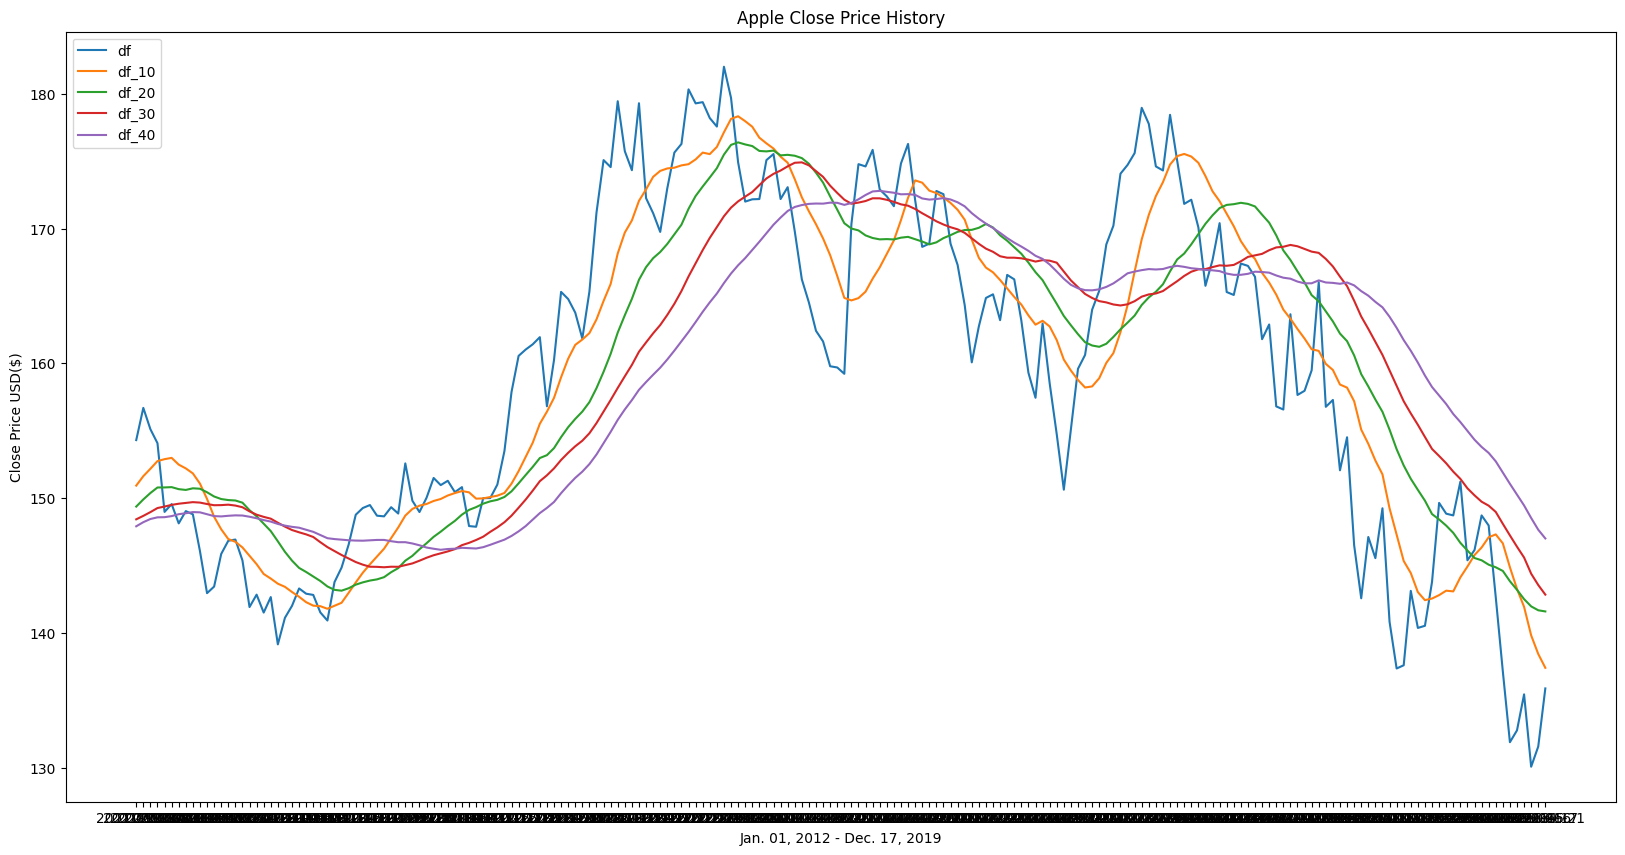

In [ ]:
#Visualize the data
plt.figure(figsize=(20,10))
plt.plot(df['Close'].tail(200), label='df')
plt.plot(df_10['Close'].tail(200), label='df_10')
plt.plot(df_20['Close'].tail(200), label='df_20')
plt.plot(df_30['Close'].tail(200), label='df_30')
plt.plot(df_40['Close'].tail(200), label='df_40')
plt.title('Apple Close Price History')
plt.xlabel('Jan. 01, 2012 - Dec. 17, 2019')
plt.ylabel('Close Price USD($)')
plt.legend(loc='upper left')
plt.show()

搜尋最佳參數（要跑很久不要隨便跑）

In [ ]:
import keras_tuner as kt
import tensorflow as tf
import numpy as np

# 確保設定隨機種子，讓搜索過程可以重現
np.random.seed(42)
tf.random.set_seed(42)

# 1. 建立一個可以接收超參數 (hp) 的模型建構函數
def build_model(hp):
    model = tf.keras.models.Sequential()

    # --- 在此定義您想搜索的參數範圍 ---
    # LSTM 第一層的單元數：在 64 到 256 之間，以 32 為間隔去嘗試 (64, 96, 128...)
    hp_units_1 = hp.Int('units_1', min_value=64, max_value=256, step=32)
    # Dropout 第一層的比率：嘗試 0.1, 0.2, 0.3
    hp_dropout_1 = hp.Float('dropout_1', min_value=0.1, max_value=0.3, step=0.1)

    # LSTM 第二層的單元數
    hp_units_2 = hp.Int('units_2', min_value=64, max_value=256, step=32)
    # Dropout 第二層的比率
    hp_dropout_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.3, step=0.1)

    # 學習率：嘗試 0.001, 0.0005, 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 5e-4, 1e-4])

    # --- 根據上面的參數建立模型 ---
    model.add(tf.keras.layers.LSTM(units=hp_units_1, return_sequences=True, input_shape=(window_size, 1)))
    model.add(tf.keras.layers.Dropout(rate=hp_dropout_1))
    model.add(tf.keras.layers.LSTM(units=hp_units_2, return_sequences=False))
    model.add(tf.keras.layers.Dropout(rate=hp_dropout_2))
    model.add(tf.keras.layers.Dense(1))

    # 編譯模型
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss='mean_squared_error')

    return model

# 2. 實例化 Tuner
# 我們使用 Hyperband，這是一種高效的搜索演算法
tuner = kt.Hyperband(build_model,
                     objective='val_loss', # 優化目標：最小化驗證集損失
                     max_epochs=100,       # 每個模型最多訓練 100 個週期
                     factor=3,
                     directory='my_dir',   # 存放結果的資料夾
                     project_name='aapl_stock_tuning')

# 3. 設定 EarlyStopping 回調
# 如果一個模型 10 個週期沒進步就提早停止，以加速搜索
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# 4. 開始搜索！
# 假設 x_train, y_train, x_val, y_val 已準備好
print("--- 開始超參數搜索 ---")
tuner.search(x_train, y_train, epochs=100, validation_data=(x_val, y_val), callbacks=[stop_early])
print("--- 搜索完成 ---")

# 5. 取得最佳的超參數組合
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
搜索完成！最佳超參數組合如下：
- 第一層 LSTM 單元數: {best_hps.get('units_1')}
- 第一層 Dropout 率: {best_hps.get('dropout_1'):.2f}
- 第二層 LSTM 單元數: {best_hps.get('units_2')}
- 第二層 Dropout 率: {best_hps.get('dropout_2'):.2f}
- 學習率: {best_hps.get('learning_rate')}
""")

NameError: name 'window_size' is not defined

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 56, 64)         │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 28, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 28, 224)        │       258,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 224)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 96)             │       123,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 382,689 (1.46 MB)

 Trainable params: 382,689 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

--- 開始訓練模型 ---
Epoch 1/100
55/55 - 5s - 95ms/step - loss: 0.0098 - val_loss: 0.0174
Epoch 2/100
55/55 - 1s - 15ms/step - loss: 0.0020 - val_loss: 0.0108
Epoch 3/100
55/55 - 1s - 16ms/step - loss: 0.0019 - val_loss: 0.0095
Epoch 4/100
55/55 - 1s - 16ms/step - loss: 0.0021 - val_loss: 0.0062
Epoch 5/100
55/55 - 1s - 15ms/step - loss: 0.0015 - val_loss: 0.0064
Epoch 6/100
55/55 - 1s - 20ms/step - loss: 0.0012 - val_loss: 0.0057
Epoch 7/100
55/55 - 1s - 13ms/step - loss: 0.0013 - val_loss: 0.0065
Epoch 8/100
55/55 - 1s - 13ms/step - loss: 0.0011 - val_loss: 0.0050
Epoch 9/100
55/55 - 1s - 22ms/step - loss: 0.0010 - val_loss: 0.0038
Epoch 10/100
55/55 - 1s - 11ms/step - loss: 0.0012 - val_loss: 0.0062
Epoch 11/100
55/55 - 1s - 9ms/step - loss: 9.8743e-04 - val_loss: 0.0039
Epoch 12/100
55/55 - 1s - 12ms/step - loss: 9.2604e-04 - val_loss: 0.0046
Epoch 13/100
55/55 - 1s - 20ms/step - loss: 9.2916e-04 - val_loss: 0.0100
Epoch 14/100
55/55 - 1s - 13ms/step - loss: 8.7043e-04 - val_loss: 0.0028

,Metric,Value
0,MSE,241.427013
1,RMSE,15.537922
2,MAE,13.907376
3,R²,0.555901



--- 本次實驗使用的超參數 ---
模型架構: CNN-LSTM
Conv1D 濾波器數量: 64
Conv1D 核心大小: 5
第一層 LSTM 單元數: 224
第一層 Dropout 率: 0.2
第二層 LSTM 單元數: 96
第二層 Dropout 率: 0.1
學習率 (Learning Rate): 0.001
批次大小 (Batch Size): 32
實際訓練週期 (Epochs): 31 / 100


/tmp/ipython-input-24-3385379657.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_plot['Predictions'] = predictions


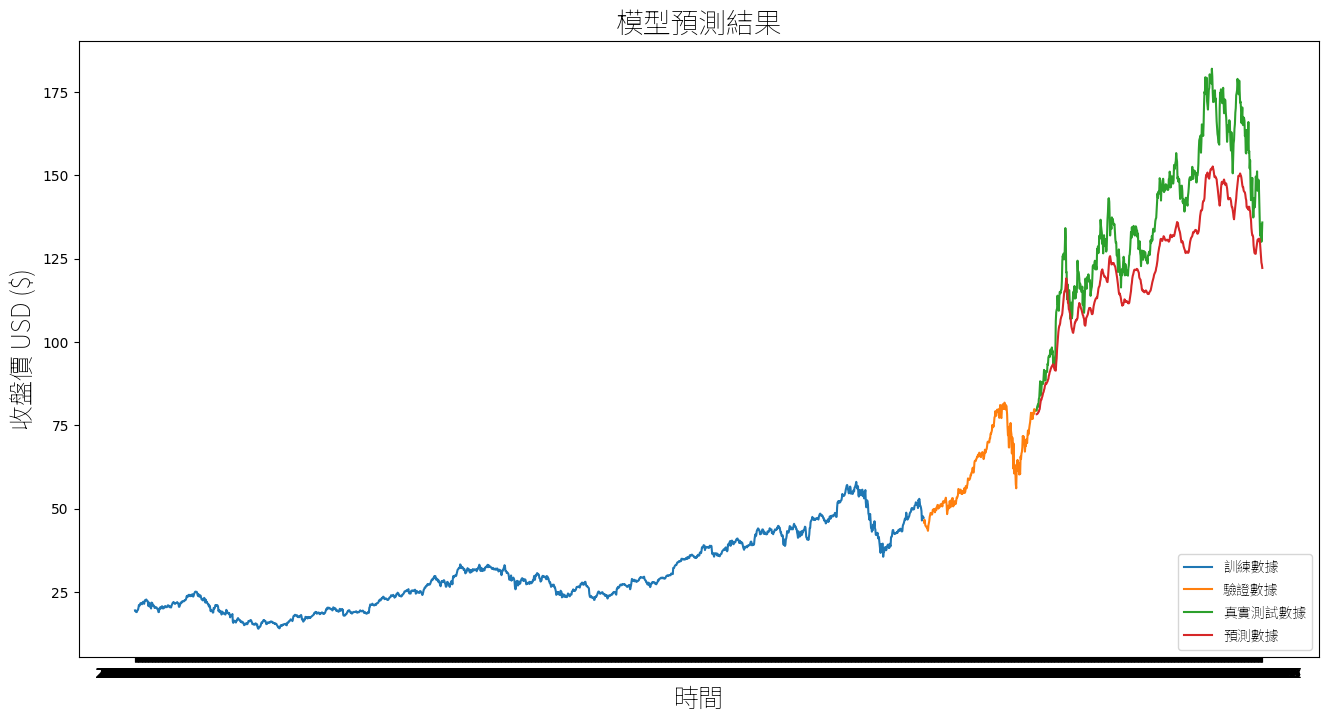

In [ ]:
# --- 修正後的數據準備與模型評估流程 ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
data = df
# 1. 取得收盤價數據
close_prices = data.filter(['Close']).values
window_size = 60

# 2. 數據分割 (70% 訓練, 10% 驗證, 20% 測試)
total_len = len(close_prices)
train_len = int(total_len * 0.7)
val_len = int(total_len * 0.1)
test_len = total_len - train_len - val_len

train_data = close_prices[0:train_len]
val_data = close_prices[train_len:train_len + val_len]
test_data = close_prices[train_len + val_len:]

# 3. 數據標準化 (Scaler 只在訓練數據上 fit)
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)

# 4. 建立訓練、驗證、測試序列 (確保數據連續性)
def create_dataset_with_context(data, scaled_data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])
    return np.array(X), np.array(y)

# 訓練序列
x_train, y_train = create_dataset_with_context(train_data, train_scaled, window_size)

# 驗證序列 (包含訓練數據的尾部作為上下文)
val_input_scaled = scaler.transform(close_prices[train_len - window_size : train_len + val_len])
x_val, y_val = create_dataset_with_context(val_input_scaled, val_input_scaled, window_size)

# 測試序列 (包含驗證數據的尾部作為上下文)
test_input_scaled = scaler.transform(close_prices[train_len + val_len - window_size : ])
x_test, y_test = create_dataset_with_context(test_input_scaled, test_input_scaled, window_size)


# 5. 重塑數據以符合 LSTM 輸入格式 (samples, time_steps, features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# 在建立模型前加入這幾行
np.random.seed(42)
tf.random.set_seed(42)

###### --- 模型建立與訓練 (這部分與您的代碼相同) ---
###model = Sequential()
###model.add(LSTM(50, return_sequences=True, input_shape=(window_size, 1)))
###model.add(LSTM(50))
###model.add(Dense(1))
###model.compile(optimizer='adam', loss='mean_squared_error')

# CNN 層設定
####CONV_FILTERS = 64
####CONV_KERNEL_SIZE = 5

# LSTM 層設定
LSTM_UNITS_1 = 224
DROPOUT_1 = 0.2
LSTM_UNITS_2 = 96
DROPOUT_2 = 0.1

# 訓練過程設定
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 100

model = Sequential()
model.add(Conv1D(filters=CONV_FILTERS, kernel_size=CONV_KERNEL_SIZE, activation='relu', input_shape=(window_size, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(LSTM_UNITS_1, return_sequences=True))
model.add(Dropout(DROPOUT_1))
model.add(LSTM(LSTM_UNITS_2, return_sequences=False))
model.add(Dropout(DROPOUT_2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary() # 可以印出模型結構確認

# 設定回調函數

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')


# 開始訓練
print("--- 開始訓練模型 ---")
history = model.fit(
    x_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, model_checkpoint],
    verbose=2
)
print("--- 模型訓練完成 ---")



# --- 正確的預測與評估 ---
########不要用
###from keras.models import load_model
###best_model = load_model('best_model.keras')
###predictions = best_model.predict(x_test)
########

# 進行預測
predictions_scaled = model.predict(x_test)

# 將預測結果反標準化，還原為原始股價尺度
predictions = scaler.inverse_transform(predictions_scaled)

# 取得真實的股價 (y_test_unscaled) 來比較
y_test_unscaled = test_data

# 計算評估指標
mse = mean_squared_error(y_test_unscaled, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_unscaled, predictions)
r2 = r2_score(y_test_unscaled, predictions)
# --- 新增 Adjusted R² 計算 ---
####n = len(y_test_unscaled)  # n 為樣本數
####k = 1                     # k 為特徵數 (此處為 1)
####adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
# 整理成 DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R²'],
    'Value': [mse, rmse, mae, r2]
})

# === 9. 印出最終實驗報告 ===
# =======================================================
print("\n" + "="*40)
print("          最終實驗報告")
print("="*40)

print("\n--- 模型評估結果 ---")
display(metrics_df)

print("\n--- 本次實驗使用的超參數 ---")
print(f"模型架構: CNN-LSTM")
print(f"Conv1D 濾波器數量: {CONV_FILTERS}")
print(f"Conv1D 核心大小: {CONV_KERNEL_SIZE}")
print(f"第一層 LSTM 單元數: {LSTM_UNITS_1}")
print(f"第一層 Dropout 率: {DROPOUT_1}")
print(f"第二層 LSTM 單元數: {LSTM_UNITS_2}")
print(f"第二層 Dropout 率: {DROPOUT_2}")
print(f"學習率 (Learning Rate): {LEARNING_RATE}")
print(f"批次大小 (Batch Size): {BATCH_SIZE}")
print(f"實際訓練週期 (Epochs): {len(history.history['loss'])} / {EPOCHS}")
print("="*40)

# --- 結果可視化 ---
plt.figure(figsize=(16,8))
plt.title('模型預測結果', fontproperties=myfont, fontsize=20)
plt.xlabel('時間', fontproperties=myfont, fontsize=18)
plt.ylabel('收盤價 USD ($)', fontproperties=myfont, fontsize=18)


# 為了繪圖，我們建立一個包含預測值的 DataFrame
train_plot = data[:train_len]
validation_plot = data[train_len:train_len + val_len]
test_plot = data[train_len + val_len:]
test_plot['Predictions'] = predictions

# plt.plot() 中移除 fontproperties
plt.plot(train_plot['Close'], label='訓練數據')
plt.plot(validation_plot['Close'], label='驗證數據')
plt.plot(test_plot['Close'], label='真實測試數據')
plt.plot(test_plot['Predictions'], label='預測數據')

# 在 plt.legend() 中使用 prop 參數設定圖例的字型
plt.legend(loc='lower right', prop=myfont)
plt.show()

GRU模型

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 60, 128)        │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,617 (342.25 KB)

 Trainable params: 87,617 (342.25 KB)

 Non-trainable params: 0 (0.00 B)

--- 開始訓練模型 ---
Epoch 1/100
55/55 - 13s - 244ms/step - loss: 0.0197 - val_loss: 0.0067 - learning_rate: 5.0000e-04
Epoch 2/100
55/55 - 9s - 156ms/step - loss: 0.0021 - val_loss: 0.0032 - learning_rate: 5.0000e-04
Epoch 3/100
55/55 - 6s - 118ms/step - loss: 0.0021 - val_loss: 0.0034 - learning_rate: 5.0000e-04
Epoch 4/100
55/55 - 11s - 191ms/step - loss: 0.0018 - val_loss: 0.0026 - learning_rate: 5.0000e-04
Epoch 5/100
55/55 - 11s - 204ms/step - loss: 0.0018 - val_loss: 0.0029 - learning_rate: 5.0000e-04
Epoch 6/100
55/55 - 11s - 200ms/step - loss: 0.0017 - val_loss: 0.0029 - learning_rate: 5.0000e-04
Epoch 7/100
55/55 - 8s - 150ms/step - loss: 0.0015 - val_loss: 0.0030 - learning_rate: 5.0000e-04
Epoch 8/100
55/55 - 12s - 211ms/step - loss: 0.0017 - val_loss: 0.0027 - learning_rate: 5.0000e-04
Epoch 9/100
55/55 - 11s - 199ms/step - loss: 0.0015 - val_loss: 0.0025 - learning_rate: 5.0000e-04
Epoch 10/100
55/55 - 10s - 174ms/step - loss: 0.0015 - val_loss: 0.0021 - learning_rate: 5.0000e-

,Metric,Value
0,MSE,119.666727
1,RMSE,10.939229
2,MAE,9.473228
3,R²,0.779876



--- 本次實驗使用的超參數 ---
模型架構: Stacked GRU
第一層 GRU 單元數: 128
第一層 Dropout 率: 0.2
第二層 GRU 單元數: 64
第二層 Dropout 率: 0.2
學習率 (Learning Rate): 0.0005
批次大小 (Batch Size): 32
實際訓練週期 (Epochs): 23 / 100


/tmp/ipython-input-22-4282311322.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_plot['Predictions'] = predictions


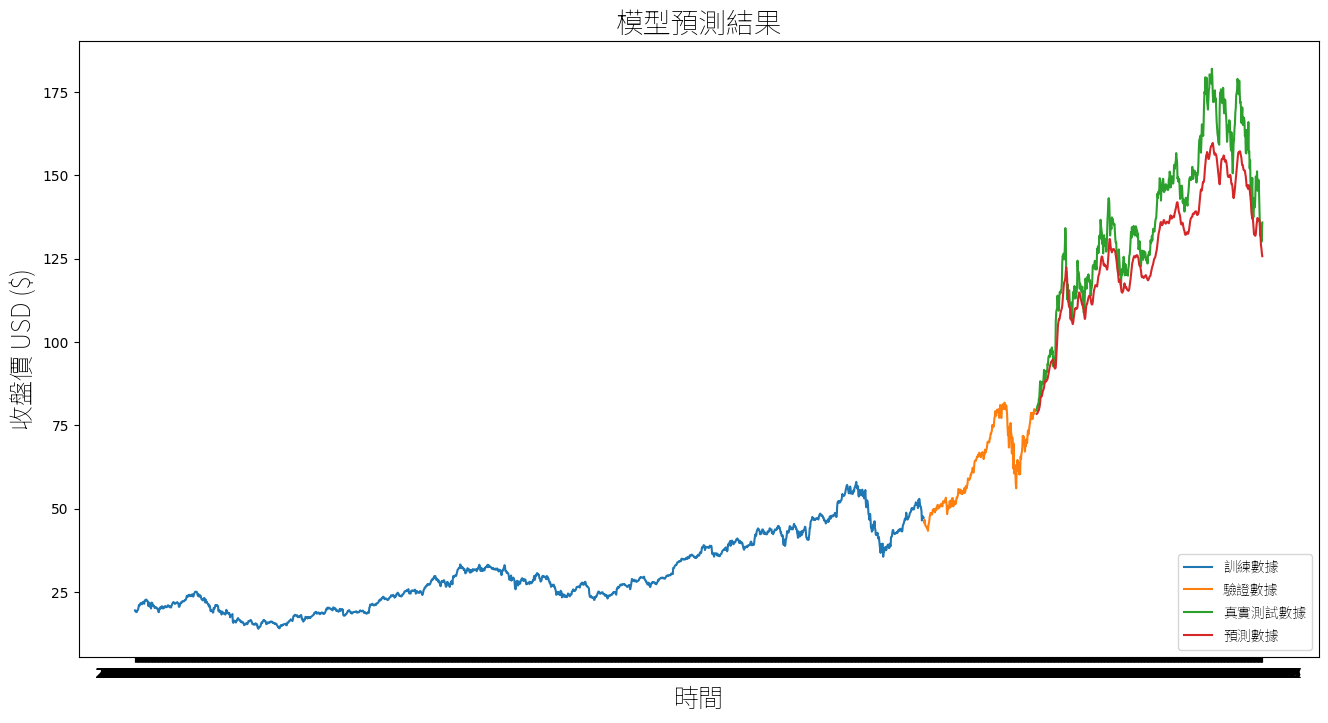

In [ ]:
# --- 修正後的數據準備與模型評估流程 ---
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import GRU, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
data = df
# 1. 取得收盤價數據
close_prices = data.filter(['Close']).values
window_size = 60

# 2. 數據分割 (70% 訓練, 10% 驗證, 20% 測試)
total_len = len(close_prices)
train_len = int(total_len * 0.7)
val_len = int(total_len * 0.1)
test_len = total_len - train_len - val_len

train_data = close_prices[0:train_len]
val_data = close_prices[train_len:train_len + val_len]
test_data = close_prices[train_len + val_len:]

# 3. 數據標準化 (Scaler 只在訓練數據上 fit)
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)

# 4. 建立訓練、驗證、測試序列 (確保數據連續性)
def create_dataset_with_context(data, scaled_data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(scaled_data[i-window_size:i, 0])
        y.append(scaled_data[i, 0])
    return np.array(X), np.array(y)

# 訓練序列
x_train, y_train = create_dataset_with_context(train_data, train_scaled, window_size)

# 驗證序列 (包含訓練數據的尾部作為上下文)
val_input_scaled = scaler.transform(close_prices[train_len - window_size : train_len + val_len])
x_val, y_val = create_dataset_with_context(val_input_scaled, val_input_scaled, window_size)

# 測試序列 (包含驗證數據的尾部作為上下文)
test_input_scaled = scaler.transform(close_prices[train_len + val_len - window_size : ])
x_test, y_test = create_dataset_with_context(test_input_scaled, test_input_scaled, window_size)


# 5. 重塑數據以符合 LSTM 輸入格式 (samples, time_steps, features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# 在建立模型前加入這幾行
np.random.seed(42)
tf.random.set_seed(42)

## --- GRU 模型整合式實驗區塊：在此調整參數並執行 ---

# =======================================================
# === 1. GRU 模型超參數設定 (請在此處集中修改) ===
# =======================================================
# GRU 層設定
GRU_UNITS_1 = 128
DROPOUT_1 = 0.2
GRU_UNITS_2 = 64
DROPOUT_2 = 0.2

# 訓練過程設定
LEARNING_RATE = 0.001
BATCH_SIZE = 32
EPOCHS = 100


model = Sequential()
model.add(GRU(units=GRU_UNITS_1, return_sequences=True, input_shape=(window_size, 1)))
model.add(Dropout(rate=DROPOUT_1))
model.add(GRU(units=GRU_UNITS_2, return_sequences=False))
model.add(Dropout(rate=DROPOUT_2))
model.add(Dense(1))
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()


# 設定回調函數

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_gru_model.keras', save_best_only=True, monitor='val_loss')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# 開始訓練
print("--- 開始訓練模型 ---")
history = model.fit(
    x_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, model_checkpoint, lr_scheduler],
    verbose=2
)
print("--- 模型訓練完成 ---")




# --- 正確的預測與評估 ---
########不要用
###from keras.models import load_model
###best_model = load_model('best_model.keras')
###predictions = best_model.predict(x_test)
########

# 進行預測
predictions_scaled = model.predict(x_test)

# 將預測結果反標準化，還原為原始股價尺度
predictions = scaler.inverse_transform(predictions_scaled)

# 取得真實的股價 (y_test_unscaled) 來比較
y_test_unscaled = test_data

# 計算評估指標
mse = mean_squared_error(y_test_unscaled, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_unscaled, predictions)
r2 = r2_score(y_test_unscaled, predictions)
# --- 新增 Adjusted R² 計算 ---
####n = len(y_test_unscaled)  # n 為樣本數
####k = 1                     # k 為特徵數 (此處為 1)
####adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
# 整理成 DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R²'],
    'Value': [mse, rmse, mae, r2]
})

# =======================================================
# === 9. 印出最終實驗報告 ===
# =======================================================
print("\n" + "="*40)
print("          最終實驗報告")
print("="*40)

print("\n--- 模型評估結果 ---")
display(metrics_df)

print("\n--- 本次實驗使用的超參數 ---")
print(f"模型架構: Stacked GRU")
print(f"第一層 GRU 單元數: {GRU_UNITS_1}")
print(f"第一層 Dropout 率: {DROPOUT_1}")
print(f"第二層 GRU 單元數: {GRU_UNITS_2}")
print(f"第二層 Dropout 率: {DROPOUT_2}")
print(f"學習率 (Learning Rate): {LEARNING_RATE}")
print(f"批次大小 (Batch Size): {BATCH_SIZE}")
print(f"實際訓練週期 (Epochs): {len(history.history['loss'])} / {EPOCHS}")
print("="*40)

# --- 結果可視化 ---
plt.figure(figsize=(16,8))
plt.title('模型預測結果', fontproperties=myfont, fontsize=20)
plt.xlabel('時間', fontproperties=myfont, fontsize=18)
plt.ylabel('收盤價 USD ($)', fontproperties=myfont, fontsize=18)


# 為了繪圖，我們建立一個包含預測值的 DataFrame
train_plot = data[:train_len]
validation_plot = data[train_len:train_len + val_len]
test_plot = data[train_len + val_len:]
test_plot['Predictions'] = predictions

# plt.plot() 中移除 fontproperties
plt.plot(train_plot['Close'], label='訓練數據')
plt.plot(validation_plot['Close'], label='驗證數據')
plt.plot(test_plot['Close'], label='真實測試數據')
plt.plot(test_plot['Predictions'], label='預測數據')

# 在 plt.legend() 中使用 prop 參數設定圖例的字型
plt.legend(loc='lower right', prop=myfont)
plt.show()

In [ ]:
# Create a new dataframe with only the 'Close column
data = df.filter(['Close'])
data.head()

,Close
Date,
2012-03-01,19.445356
2012-03-02,19.470715
2012-03-05,19.041430
2012-03-06,18.937857
2012-03-07,18.953215


In [ ]:
dataset = data.values

In [ ]:
from sklearn.model_selection import train_test_split

# close 為你的原始一維股價array
# 先train/test
train, test = train_test_split(close, test_size=0.2, shuffle=False)
# 再從train裡切val
train, val = train_test_split(train, test_size=0.125, shuffle=False)  # 0.125 = 10%總資料

print(len(train), len(val), len(test))

1815 260 519


In [ ]:
# 70% 訓練，10% 驗證，20% 測試
#total_len = len(close)
#train_size = int(total_len * 0.7)
#val_size = int(total_len * 0.1)
#test_size = total_len - train_size - val_size

#train = close[:train_size]
#val = close[train_size:train_size + val_size]
#test = close[train_size + val_size:]

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train.reshape(-1, 1))
val_scaled = scaler.transform(val.reshape(-1, 1))
test_scaled = scaler.transform(test.reshape(-1, 1))

In [ ]:
def create_sequences(data, window=60):
    x, y = [], []
    for i in range(window, len(data)):
        x.append(data[i-window:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

window_size = 60
x_train, y_train = create_sequences(train_scaled, window_size)
x_val, y_val = create_sequences(val_scaled, window_size)
x_test, y_test = create_sequences(test_scaled, window_size)

# LSTM 需求：三維輸入
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_val = x_val.reshape((x_val.shape[0], x_val.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

In [ ]:
def create_lstm_sequences(data, window=60):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# 假設你有 train_scaled, val_scaled, test_scaled
window_size = 60
x_train, y_train = create_lstm_sequences(train_scaled, window_size)
x_val, y_val = create_lstm_sequences(val_scaled, window_size)
x_test, y_test = create_lstm_sequences(test_scaled, window_size)

print(x_train.shape, y_train.shape)  # 應該 shape[0] 一樣

(1755, 60) (1755,)


In [ ]:
#x_train, y_train = np.array(x_train), np.array(y_train)

In [ ]:
#x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
#x_train.shape

In [ ]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(window_size, 1)))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
history = model.fit(
    x_train, y_train,
    epochs=10, batch_size=32,
    validation_data=(x_val, y_val),
    verbose=2
)

Epoch 1/10
55/55 - 8s - 142ms/step - loss: 0.0122 - val_loss: 0.0099
Epoch 2/10
55/55 - 3s - 53ms/step - loss: 8.0062e-04 - val_loss: 0.0092
Epoch 3/10
55/55 - 6s - 110ms/step - loss: 7.8919e-04 - val_loss: 0.0092
Epoch 4/10
55/55 - 4s - 75ms/step - loss: 7.1889e-04 - val_loss: 0.0076
Epoch 5/10
55/55 - 5s - 93ms/step - loss: 6.9302e-04 - val_loss: 0.0086
Epoch 6/10
55/55 - 4s - 65ms/step - loss: 6.5598e-04 - val_loss: 0.0085
Epoch 7/10
55/55 - 4s - 81ms/step - loss: 6.3005e-04 - val_loss: 0.0077
Epoch 8/10
55/55 - 5s - 92ms/step - loss: 5.4997e-04 - val_loss: 0.0105
Epoch 9/10
55/55 - 7s - 119ms/step - loss: 5.7706e-04 - val_loss: 0.0069
Epoch 10/10
55/55 - 3s - 53ms/step - loss: 5.1083e-04 - val_loss: 0.0065


In [ ]:

test_data = scaled_data[training_data_len-60: , :]
#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, : ]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

In [ ]:
# Convert the data to a numpy array
x_test = np.array(x_test)

In [ ]:
# 預測
lstm_predictions = model.predict(x_test)
# 反標準化（回到原始價格單位）
lstm_predictions = scaler.inverse_transform(lstm_predictions)
y_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 計算分數（正確寫法）
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_true, lstm_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, lstm_predictions)
r2 = r2_score(y_true, lstm_predictions)

print(f"LSTM -- MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.3f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
LSTM -- MSE: 37002076.12, RMSE: 6082.93, MAE: 5998.18, R²: -34.725


In [ ]:
print(lstm_predictions[0:5], y_test[0:5])

[[31.119099]
 [31.170351]
 [31.230385]
 [31.28037 ]
 [31.360014]] [[80.834999]
 [81.279999]
 [80.580002]
 [82.875   ]
 [83.364998]]


In [ ]:
mse = np.mean((lstm_predictions - y_test)**2)
rmse = np.sqrt(mse)
mse, rmse

(np.float64(8584.854173310789), np.float64(92.65448814445412))

/tmp/ipython-input-256-1007574305.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = lstm_predictions


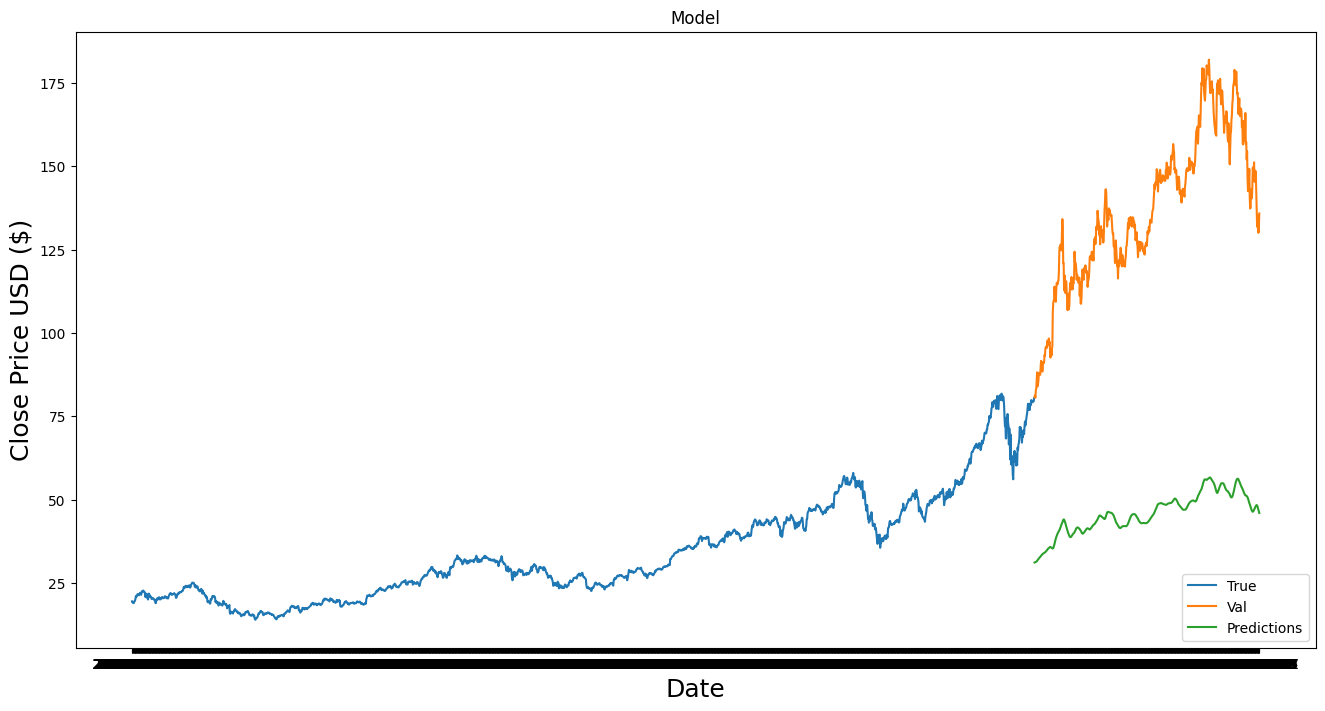

In [ ]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = lstm_predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['True', 'Val', 'Predictions'], loc = 'lower right')
plt.show()

In [ ]:
lstm_predictions = np.array(lstm_predictions)

In [ ]:
#baseline 時序預測流程（「預測明天股價等於今天」），並且計算 R²、MAE、RMSE，看分數是否正常。
#	•	R² 應該會大於 0（通常在 0.9 左右，因為股票短期自相關很高）
#•	MAE 應該會接近標準差（這裡 std 約 44，預測誤差也會在這個級距內）

# 讀入你的資料
df = pd.read_csv("/content/drive/MyDrive/AAPL.csv", header=None, names=["Date", "Open", "High", "Low", "Close", "Adj Close", "Volume"],skiprows=1)
close = df["Close"].astype(float).values
print(df['Close'].head())
print(df.dtypes)
# baseline：預測明天等於今天
y_true = close[1:]        # 第2天到最後一天的真實收盤價
y_pred = close[:-1]       # 第1天到倒數第2天的預測值（預測"明天等於今天"）

# 評分
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")

0    19.445356
1    19.470715
2    19.041430
3    18.937857
4    18.953215
Name: Close, dtype: float64
Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
MSE: 1.94
RMSE: 1.39
MAE: 0.75
R²: 0.999


In [ ]:
# 計算各種指標
mse = mean_squared_error(y_test, lstm_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, lstm_predictions)
r2 = r2_score(y_test, lstm_predictions)

# Adjusted R2 計算：需要知道自由度（樣本數與解釋變數數）
n = len(y_test)
# LSTM 預測是單一輸入序列通常不會有多個自變數，但你可以依你模型輸入維度（特徵數）決定 k
# 如果你的 LSTM 只有 close 價一個特徵，k=1
k = 1  # 請依你的模型輸入特徵數正確填寫
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

# 整理成 DataFrame
metrics_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R²', 'Adjusted R²'],
    'Value': [mse, rmse, mae, r2, adjusted_r2]
})

display(metrics_df)

,Metric,Value
0,MSE,8584.854173
1,RMSE,92.654488
2,MAE,91.028049
3,R²,-15.097658
4,Adjusted R²,-15.128855
